In [1]:
import numpy as np
import pandas as pd
import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import catboost as cat
from mllib.params import FieldNames, FileNames
from mllib.utils import load_pickle

In [2]:
def make_x_y(x_tr, x_val, flag='val'):
    y_tr = x_tr['redemption_status'].values
    del x_tr['redemption_status']

    if flag == 'val':
        y_val = x_val['redemption_status'].values
        del x_val['redemption_status']
    else:
        y_val = None
    return x_tr, y_tr, x_val, y_val


def get_rank_features(df):
    df['cust_coupon_rank1'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_0'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank2'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_1'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank3'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_2'].rank('max')/df['customer_campaign_count']
    df['customer_rank1'] = df.groupby(['customer_id'])['common_item_set_0'].rank('max')/df.groupby('customer_id').size()
    # df['customer_rank2'] = df.groupby(['customer_id'])['common_item_set_1'].rank('max')/df.groupby('customer_id').size()
    # df['customer_rank3'] = df.groupby(['customer_id'])['common_item_set_2'].rank('max')/df.groupby('customer_id').size()
    df['campaign_rank1'] = df.groupby(['campaign_id'])['common_item_set_0'].rank('max')/df.groupby('campaign_id').size()
    #df['campaign_rank2'] = df.groupby(['campaign_id'])['common_item_set_1'].rank('max')/df.groupby('campaign_id').size()
    #df['campaign_rank3'] = df.groupby(['campaign_id'])['common_item_set_2'].rank('max')/df.groupby('campaign_id').size()
    df['coupon_rank1'] = df.groupby(['coupon_id'])['common_item_set_0'].rank('max')/df.groupby('coupon_id').size()
    #df['coupon_rank2'] = df.groupby(['coupon_id'])['common_item_set_1'].rank('max')/df.groupby('coupon_id').size()

    return df


def load_data(flag='val'):
    if flag == 'val':
        x_tr = load_pickle(FileNames.tr_features_v2)
        x_val = load_pickle(FileNames.val_features_v2)
    elif flag == 'test':
        x_tr = load_pickle(FileNames.train_features_v2)
        x_val = load_pickle(FileNames.test_features_v2)
    
    return make_x_y(x_tr, x_val, flag=flag)


def map_campign_id(x_tr, x_val, flag='val'):
    if flag == 'val':
        tr = load_pickle(FileNames.tr_v2)
        val = load_pickle(FileNames.val_v2)
    elif flag == 'test':
        tr = load_pickle(FileNames.train_v2)
        val = load_pickle(FileNames.test_v2)
        
    x_tr['campaign_id'] = tr['campaign_id'].values
    x_val['campaign_id'] = val['campaign_id'].values
    return x_tr, x_val

In [3]:
x_tr, y_tr, x_val, y_val = load_data('val')
x_tr, x_val = map_campign_id(x_tr, x_val, 'val')

In [4]:
n_feats = x_tr.shape[1] - 1
n_feats

390

In [5]:
x_tr = get_rank_features(x_tr)
x_val = get_rank_features(x_val)

In [21]:
cat_params = {
    #"use_best_model": True,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 1350,
    "depth": 4,
    "learning_rate": 0.01,
    "l2_leaf_reg": 10,
    "random_strength": 1.0,
    #"od_type": "Iter",
    #"od_wait": 200,
    "bagging_temperature": 0.00,
    "min_data_in_leaf": 500,
    "max_leaves": 4,
    "grow_policy": "Lossguide",
    #"rsm": 0.8,
    "task_type": "GPU",
    "scale_pos_weight": 1.0,
    "random_seed": 1
    }

model = cat.CatBoostClassifier(**cat_params)

feats = [f for f in x_tr.columns if ('coupon_details' not in f) and 
         (f not in ['campaign_id', 'customer_campaign_count',
                    'unq_item_hist1', 'unq_item_hist2', 'unq_item_hist3',
                    ])] + ['coupon_details_quantity_0']
#xx_tr = qnt.fit_transform(x_tr[feats].fillna(-999))
#xx_val = qnt.fit_transform(x_val[feats].fillna(-999))
val_preds_all = []
for i in range(5):
    model.fit(x_tr[feats], y_tr, eval_set=[(x_val[feats], y_val)], verbose=50) 
    val_preds = model.predict_proba(x_val[feats])[:, 1]
    val_preds_all.append(val_preds)

0:	learn: 0.6502330	test: 0.6712565	best: 0.6712565 (0)	total: 10.2ms	remaining: 13.7s
50:	learn: 0.8567452	test: 0.8801089	best: 0.8801089 (50)	total: 540ms	remaining: 13.7s
100:	learn: 0.8993230	test: 0.9081627	best: 0.9081627 (100)	total: 1.13s	remaining: 13.9s
150:	learn: 0.9160463	test: 0.9210444	best: 0.9215026 (134)	total: 1.72s	remaining: 13.7s
200:	learn: 0.9197100	test: 0.9234623	best: 0.9235511 (199)	total: 2.2s	remaining: 12.6s
250:	learn: 0.9251345	test: 0.9297033	best: 0.9297033 (250)	total: 2.69s	remaining: 11.8s
300:	learn: 0.9292654	test: 0.9336531	best: 0.9336531 (300)	total: 3.16s	remaining: 11s
350:	learn: 0.9328615	test: 0.9364521	best: 0.9364521 (350)	total: 3.65s	remaining: 10.4s
400:	learn: 0.9355123	test: 0.9385256	best: 0.9385256 (400)	total: 4.14s	remaining: 9.79s
450:	learn: 0.9376121	test: 0.9399242	best: 0.9399242 (450)	total: 4.61s	remaining: 9.19s
500:	learn: 0.9397010	test: 0.9416050	best: 0.9416127 (499)	total: 5.08s	remaining: 8.61s
550:	learn: 0.9415

0:	learn: 0.6502330	test: 0.6712565	best: 0.6712565 (0)	total: 11.7ms	remaining: 15.8s
50:	learn: 0.8567453	test: 0.8801087	best: 0.8801087 (50)	total: 465ms	remaining: 11.8s
100:	learn: 0.8993154	test: 0.9081481	best: 0.9081481 (100)	total: 939ms	remaining: 11.6s
150:	learn: 0.9161676	test: 0.9209758	best: 0.9215776 (136)	total: 1.44s	remaining: 11.4s
200:	learn: 0.9198800	test: 0.9236892	best: 0.9236892 (200)	total: 1.94s	remaining: 11.1s
250:	learn: 0.9251308	test: 0.9296472	best: 0.9296472 (250)	total: 2.42s	remaining: 10.6s
300:	learn: 0.9293948	test: 0.9338253	best: 0.9338253 (300)	total: 2.92s	remaining: 10.2s
350:	learn: 0.9328297	test: 0.9364808	best: 0.9364808 (350)	total: 3.42s	remaining: 9.73s
400:	learn: 0.9353922	test: 0.9383323	best: 0.9383323 (400)	total: 3.91s	remaining: 9.25s
450:	learn: 0.9376659	test: 0.9401047	best: 0.9401047 (450)	total: 4.41s	remaining: 8.79s
500:	learn: 0.9395485	test: 0.9415616	best: 0.9415688 (499)	total: 4.89s	remaining: 8.29s
550:	learn: 0.9

0:	learn: 0.6502330	test: 0.6712565	best: 0.6712565 (0)	total: 12.4ms	remaining: 16.7s
50:	learn: 0.8567453	test: 0.8801098	best: 0.8801098 (50)	total: 717ms	remaining: 18.3s
100:	learn: 0.8993237	test: 0.9081650	best: 0.9081650 (100)	total: 1.31s	remaining: 16.2s
150:	learn: 0.9160618	test: 0.9210281	best: 0.9215972 (136)	total: 1.9s	remaining: 15.1s
200:	learn: 0.9202906	test: 0.9237643	best: 0.9237643 (200)	total: 2.4s	remaining: 13.7s
250:	learn: 0.9250585	test: 0.9298339	best: 0.9298339 (250)	total: 2.89s	remaining: 12.6s
300:	learn: 0.9292981	test: 0.9338868	best: 0.9338868 (300)	total: 3.38s	remaining: 11.8s
350:	learn: 0.9327463	test: 0.9365327	best: 0.9365327 (350)	total: 3.87s	remaining: 11s
400:	learn: 0.9353649	test: 0.9383639	best: 0.9383689 (395)	total: 4.37s	remaining: 10.3s
450:	learn: 0.9375775	test: 0.9401342	best: 0.9401342 (450)	total: 4.85s	remaining: 9.67s
500:	learn: 0.9397015	test: 0.9417132	best: 0.9417279 (499)	total: 5.35s	remaining: 9.07s
550:	learn: 0.94147

0:	learn: 0.6502330	test: 0.6712565	best: 0.6712565 (0)	total: 10.8ms	remaining: 14.5s
50:	learn: 0.8567452	test: 0.8801101	best: 0.8801101 (50)	total: 583ms	remaining: 14.8s
100:	learn: 0.8993139	test: 0.9081336	best: 0.9081336 (100)	total: 1.11s	remaining: 13.7s
150:	learn: 0.9160281	test: 0.9210073	best: 0.9214515 (134)	total: 1.7s	remaining: 13.5s
200:	learn: 0.9198727	test: 0.9235482	best: 0.9235482 (200)	total: 2.19s	remaining: 12.6s
250:	learn: 0.9250981	test: 0.9298027	best: 0.9298027 (250)	total: 2.68s	remaining: 11.7s
300:	learn: 0.9291115	test: 0.9335406	best: 0.9335467 (298)	total: 3.19s	remaining: 11.1s
350:	learn: 0.9327507	test: 0.9364653	best: 0.9364653 (350)	total: 3.67s	remaining: 10.4s
400:	learn: 0.9353885	test: 0.9382934	best: 0.9383158 (397)	total: 4.21s	remaining: 9.97s
450:	learn: 0.9376770	test: 0.9401267	best: 0.9401267 (450)	total: 4.71s	remaining: 9.39s
500:	learn: 0.9396372	test: 0.9415403	best: 0.9415403 (500)	total: 5.21s	remaining: 8.83s
550:	learn: 0.94

0:	learn: 0.6502330	test: 0.6712565	best: 0.6712565 (0)	total: 11.3ms	remaining: 15.3s
50:	learn: 0.8567452	test: 0.8801083	best: 0.8801083 (50)	total: 567ms	remaining: 14.5s
100:	learn: 0.8993139	test: 0.9081480	best: 0.9081480 (100)	total: 1.15s	remaining: 14.3s
150:	learn: 0.9161516	test: 0.9209822	best: 0.9216662 (134)	total: 1.82s	remaining: 14.4s
200:	learn: 0.9197825	test: 0.9235876	best: 0.9235876 (200)	total: 2.33s	remaining: 13.3s
250:	learn: 0.9250736	test: 0.9297105	best: 0.9298095 (249)	total: 2.83s	remaining: 12.4s
300:	learn: 0.9293180	test: 0.9337860	best: 0.9337860 (300)	total: 3.35s	remaining: 11.7s
350:	learn: 0.9329427	test: 0.9365535	best: 0.9365535 (350)	total: 3.89s	remaining: 11.1s
400:	learn: 0.9355175	test: 0.9384692	best: 0.9384899 (397)	total: 4.39s	remaining: 10.4s
450:	learn: 0.9377774	test: 0.9401759	best: 0.9401759 (450)	total: 4.89s	remaining: 9.75s
500:	learn: 0.9396625	test: 0.9415314	best: 0.9415314 (500)	total: 5.41s	remaining: 9.16s
550:	learn: 0.9

In [22]:
from scipy.stats import gmean
val_preds = gmean(val_preds_all, 0)
roc_auc_score(y_val, val_preds)

0.9477537766505635

In [23]:
x_train, y_train, x_test, _ = load_data('test')
x_train, x_test = map_campign_id(x_train, x_test, 'test')
x_train = get_rank_features(x_train)
x_test = get_rank_features(x_test)

In [24]:
model = cat.CatBoostClassifier(**cat_params)

#feats = [f for f in x_train.columns if ('coupon_details' not in f) and 
#         (f not in ['campaign_id', 'customer_campaign_count'])] + ['coupon_details_quantity_0']
test_preds_all = []
for i in range(5):
    model.fit(x_train[feats], y_train, verbose=50)
    test_preds = model.predict_proba(x_test[feats])[:, 1]
    test_preds_all.append(test_preds)

test_preds = gmean(test_preds_all, 0)

0:	learn: 0.6578975	total: 11.9ms	remaining: 16s
50:	learn: 0.8772309	total: 575ms	remaining: 14.6s
100:	learn: 0.8827429	total: 1.1s	remaining: 13.6s
150:	learn: 0.9253646	total: 1.67s	remaining: 13.3s
200:	learn: 0.9288343	total: 2.17s	remaining: 12.4s
250:	learn: 0.9345058	total: 2.65s	remaining: 11.6s
300:	learn: 0.9377945	total: 3.13s	remaining: 10.9s
350:	learn: 0.9400733	total: 3.62s	remaining: 10.3s
400:	learn: 0.9419774	total: 4.12s	remaining: 9.74s
450:	learn: 0.9437807	total: 4.61s	remaining: 9.19s
500:	learn: 0.9449118	total: 5.12s	remaining: 8.67s
550:	learn: 0.9458551	total: 5.6s	remaining: 8.12s
600:	learn: 0.9467030	total: 6.09s	remaining: 7.59s
650:	learn: 0.9477942	total: 6.61s	remaining: 7.09s
700:	learn: 0.9486235	total: 7.11s	remaining: 6.58s
750:	learn: 0.9494450	total: 7.59s	remaining: 6.05s
800:	learn: 0.9502950	total: 8.1s	remaining: 5.55s
850:	learn: 0.9510900	total: 8.6s	remaining: 5.04s
900:	learn: 0.9518251	total: 9.11s	remaining: 4.54s
950:	learn: 0.952680

0:	learn: 0.6578975	total: 23.2ms	remaining: 31.2s
50:	learn: 0.8772309	total: 624ms	remaining: 15.9s
100:	learn: 0.8827297	total: 1.17s	remaining: 14.5s
150:	learn: 0.9252883	total: 4.65s	remaining: 36.9s
200:	learn: 0.9270523	total: 12.4s	remaining: 1m 11s
250:	learn: 0.9344855	total: 22.7s	remaining: 1m 39s
300:	learn: 0.9379799	total: 31.8s	remaining: 1m 50s
350:	learn: 0.9399841	total: 41s	remaining: 1m 56s
400:	learn: 0.9418999	total: 50.5s	remaining: 1m 59s
450:	learn: 0.9436615	total: 59.5s	remaining: 1m 58s
500:	learn: 0.9448957	total: 1m 8s	remaining: 1m 56s
550:	learn: 0.9458922	total: 1m 18s	remaining: 1m 53s
600:	learn: 0.9467427	total: 1m 27s	remaining: 1m 48s
650:	learn: 0.9477766	total: 1m 37s	remaining: 1m 44s
700:	learn: 0.9486121	total: 1m 46s	remaining: 1m 38s
750:	learn: 0.9494534	total: 1m 54s	remaining: 1m 31s
800:	learn: 0.9502924	total: 2m 4s	remaining: 1m 25s
850:	learn: 0.9511190	total: 2m 13s	remaining: 1m 18s
900:	learn: 0.9518714	total: 2m 23s	remaining: 1

0:	learn: 0.6578975	total: 67.1ms	remaining: 1m 30s
50:	learn: 0.8772309	total: 3.89s	remaining: 1m 38s
100:	learn: 0.8827426	total: 7.71s	remaining: 1m 35s
150:	learn: 0.9253566	total: 10.8s	remaining: 1m 25s
200:	learn: 0.9288338	total: 13.9s	remaining: 1m 19s
250:	learn: 0.9345042	total: 16.8s	remaining: 1m 13s
300:	learn: 0.9377949	total: 19.7s	remaining: 1m 8s
350:	learn: 0.9400443	total: 22.8s	remaining: 1m 4s
400:	learn: 0.9419427	total: 25.9s	remaining: 1m 1s
450:	learn: 0.9437995	total: 29.1s	remaining: 58s
500:	learn: 0.9449801	total: 32.3s	remaining: 54.8s
550:	learn: 0.9459148	total: 35.5s	remaining: 51.5s
600:	learn: 0.9467897	total: 38.5s	remaining: 48s
650:	learn: 0.9478472	total: 41.7s	remaining: 44.7s
700:	learn: 0.9486670	total: 45s	remaining: 41.6s
750:	learn: 0.9495289	total: 48.6s	remaining: 38.8s
800:	learn: 0.9503218	total: 52.7s	remaining: 36.1s
850:	learn: 0.9511149	total: 56.1s	remaining: 32.9s
900:	learn: 0.9518740	total: 59.1s	remaining: 29.5s
950:	learn: 0.

0:	learn: 0.6578975	total: 74.6ms	remaining: 1m 40s
50:	learn: 0.8770574	total: 3.64s	remaining: 1m 32s
100:	learn: 0.8819818	total: 6.9s	remaining: 1m 25s
150:	learn: 0.9251634	total: 10.3s	remaining: 1m 21s
200:	learn: 0.9272148	total: 13.9s	remaining: 1m 19s
250:	learn: 0.9346339	total: 17.4s	remaining: 1m 16s
300:	learn: 0.9377416	total: 20.9s	remaining: 1m 12s
350:	learn: 0.9399753	total: 25.1s	remaining: 1m 11s
400:	learn: 0.9419152	total: 28.5s	remaining: 1m 7s
450:	learn: 0.9436013	total: 32.1s	remaining: 1m 4s
500:	learn: 0.9448850	total: 35.8s	remaining: 1m
550:	learn: 0.9458279	total: 39.3s	remaining: 56.9s
600:	learn: 0.9467101	total: 43.3s	remaining: 53.9s
650:	learn: 0.9477358	total: 46.6s	remaining: 50.1s
700:	learn: 0.9485976	total: 49.7s	remaining: 46.1s
750:	learn: 0.9493912	total: 53s	remaining: 42.2s
800:	learn: 0.9502192	total: 56.3s	remaining: 38.6s
850:	learn: 0.9509942	total: 59.5s	remaining: 34.9s
900:	learn: 0.9517412	total: 1m 2s	remaining: 31.4s
950:	learn: 

0:	learn: 0.6578975	total: 82.8ms	remaining: 1m 51s
50:	learn: 0.8772309	total: 3.53s	remaining: 1m 29s
100:	learn: 0.8827426	total: 8.27s	remaining: 1m 42s
150:	learn: 0.9252552	total: 17.6s	remaining: 2m 19s
200:	learn: 0.9292355	total: 27.2s	remaining: 2m 35s
250:	learn: 0.9346789	total: 36.4s	remaining: 2m 39s
300:	learn: 0.9378388	total: 46.2s	remaining: 2m 40s
350:	learn: 0.9400637	total: 55.6s	remaining: 2m 38s
400:	learn: 0.9420069	total: 1m 4s	remaining: 2m 32s
450:	learn: 0.9437521	total: 1m 12s	remaining: 2m 25s
500:	learn: 0.9449466	total: 1m 21s	remaining: 2m 17s
550:	learn: 0.9459268	total: 1m 30s	remaining: 2m 10s
600:	learn: 0.9468186	total: 1m 39s	remaining: 2m 3s
650:	learn: 0.9478598	total: 1m 48s	remaining: 1m 56s
700:	learn: 0.9486766	total: 1m 56s	remaining: 1m 48s
750:	learn: 0.9494597	total: 2m	remaining: 1m 35s
800:	learn: 0.9502161	total: 2m 3s	remaining: 1m 24s
850:	learn: 0.9510151	total: 2m 7s	remaining: 1m 14s
900:	learn: 0.9518165	total: 2m 10s	remaining:

/home/mohsin/kg7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


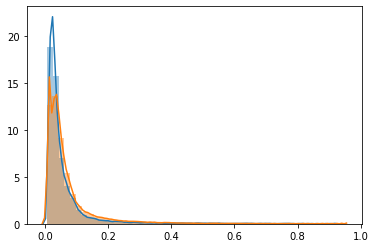

In [25]:
sns.distplot(np.sqrt(val_preds))
sns.distplot(np.sqrt(test_preds))

In [26]:
test = pd.read_csv('data/test.csv')
sub = test[['id']]
sub['redemption_status'] = test_preds
sub.head()

/home/mohsin/kg7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,redemption_status
0,3,0.334865
1,4,0.013805
2,5,0.003920
3,8,0.000721
4,10,0.000804


In [27]:
sub.to_csv('data/sub_model10.csv', index=False)

In [28]:
sub8 = pd.read_csv('data/sub_model8.csv')
sub9 = pd.read_csv('data/sub_model9.csv')

sub8.head()

,id,redemption_status
0,3,0.353429
1,4,0.005691
2,5,0.011552
3,8,0.000983
4,10,0.000822


In [29]:
from scipy.stats import gmean
sub_en = sub.copy()
sub_en['redemption_status'] = 0.7*gmean([sub8['redemption_status'], sub9['redemption_status']], 0) + 0.3*sub['redemption_status']
sub_en.head()

,id,redemption_status
0,3,0.389678
1,4,0.008891
2,5,0.009455
3,8,0.000893
4,10,0.000842


In [30]:
sub_en.to_csv('sub_en2.csv', index=False)